
=== GRIDSEARCH FULL RESULTS ===
+------------------+------------+--------+----------+----------------+-------------+---------+---------+
|      Model       | PCA n_comp | Alpha  | L1_ratio | Mean Train MSE | Mean CV MSE |   MEE   | MSE Gap |
+------------------+------------+--------+----------+----------------+-------------+---------+---------+
| LinearRegression |    None    |  None  |   None   |     1.5179     |    1.5958   |  2.4072 |  0.0779 |
| LinearRegression |     2      |  None  |   None   |     1.5968     |    1.6222   |  2.4248 |  0.0254 |
| LinearRegression |     4      |  None  |   None   |     1.5564     |    1.6029   |  2.4102 |  0.0465 |
| LinearRegression |     6      |  None  |   None   |     1.5291     |    1.5808   |  2.3948 |  0.0517 |
| LinearRegression |     8      |  None  |   None   |     1.5179     |    1.5958   |  2.4072 |  0.0779 |
|      Ridge       |    None    | 0.001  |   None   |     1.5179     |    1.5958   |  2.4072 |  0.0779 |
|      Ridge       |  

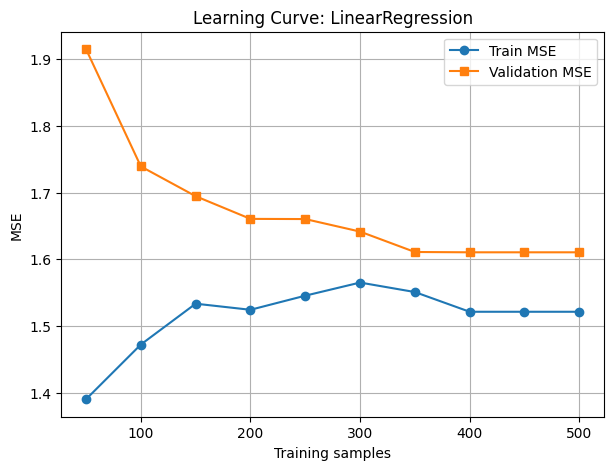

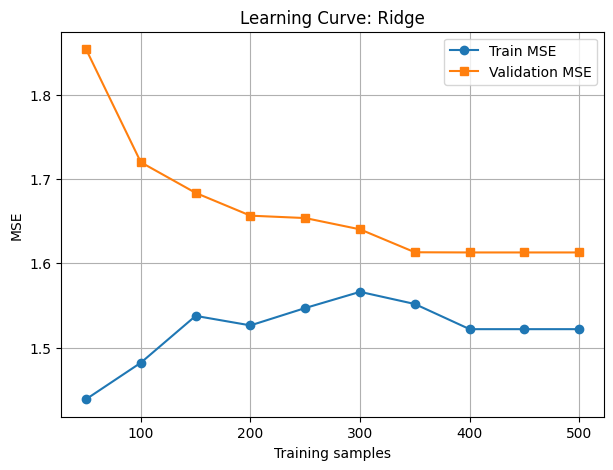

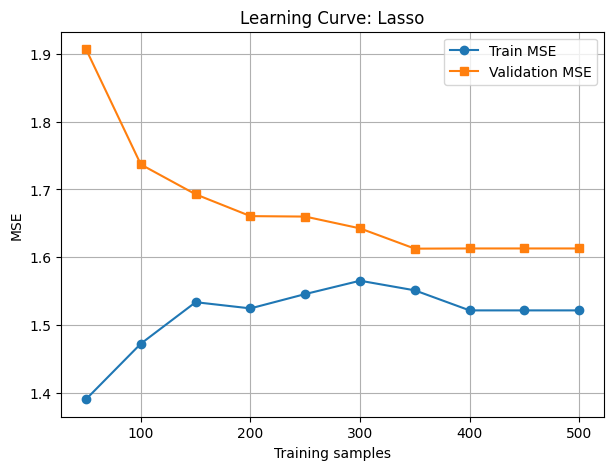

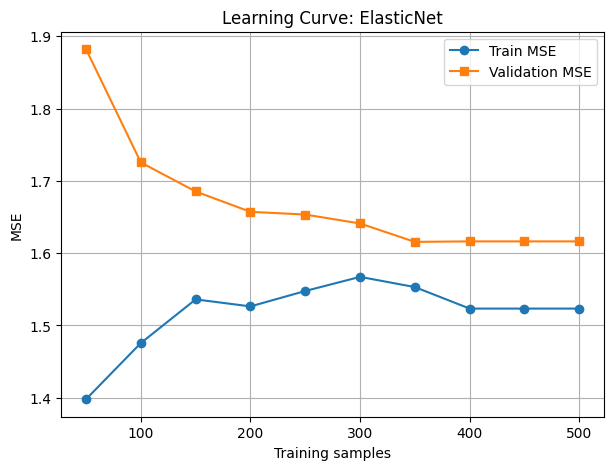

In [39]:
# =====================================
# ML-CUP25 - LINEAR MODELS (K-FOLD + METRICS + LEARNING CURVES)
# =====================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, pairwise_distances
from sklearn.base import clone
from prettytable import PrettyTable

# ======================
# 1. LOAD DATA
# ======================
TR_PATH = "/content/sample_data/ML-CUP25-TR.csv"
TS_PATH = "/content/sample_data/ML-CUP25-TS.csv"

df_tr = pd.read_csv(TR_PATH, header=None, comment="#")
df_ts = pd.read_csv(TS_PATH, header=None, comment="#")

X = df_tr.iloc[:, 1:9].values
Y = df_tr.iloc[:, 9:13].values
X_ts = df_ts.iloc[:, 1:9].values

# ======================
# 2. PIPELINES (PCA OPTIONAL)
# ======================
pipelines = {
    "LinearRegression": Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA()),
        ("model", LinearRegression())
    ]),
    "Ridge": Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA()),
        ("model", Ridge())
    ]),
    "Lasso": Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA()),
        ("model", Lasso(max_iter=10000))
    ]),
    "ElasticNet": Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA()),
        ("model", ElasticNet(max_iter=10000))
    ])
}

# ======================
# 3. PARAMETER GRIDS
# ======================
param_grids = {
    "LinearRegression": {"pca__n_components": [None, 2, 4, 6, 8]},

    # Ridge: il suggerimento era di estendere i valori alti
    "Ridge": {"pca__n_components": [None, 2, 4, 6, 8],
              "model__alpha": [0.001, 0.01, 0.1, 0.5, 1, 5, 10, 50, 100, 200, 500, 1000, 2000, 5000, 10000]}, # Aggiunti valori più alti

    # Lasso: il suggerimento era di estendere i valori alti
    "Lasso": {"pca__n_components": [None, 2, 4, 6, 8],
              "model__alpha": [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 200, 500]}, # Aggiunti valori più alti

    # ElasticNet: il suggerimento era di estendere alpha sui valori alti e l1_ratio sui valori alti (più vicini a 1)
    "ElasticNet": {"pca__n_components": [None, 2, 4, 6, 8],
                   "model__alpha": [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 200], # Aggiunti valori più alti
                   "model__l1_ratio": [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9, 0.95, 0.99]} # Aggiunti valori più alti (più vicini a 1)
}

# ======================
# 4. K-FOLD CV + GRID SEARCH
# ======================
kf = KFold(n_splits=5, shuffle=True, random_state=42)
best_models = {}
cv_scores = {}

all_results_table = PrettyTable()
all_results_table.field_names = [
    "Model", "PCA n_comp", "Alpha", "L1_ratio", "Mean Train MSE",
    "Mean CV MSE", "MEE", "MSE Gap"
]

for name, pipe in pipelines.items():
    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grids[name],
        cv=kf,
        scoring="neg_mean_squared_error",
        n_jobs=-1,
        return_train_score=True
    )
    grid.fit(X, Y)
    best_models[name] = grid.best_estimator_
    cv_scores[name] = -grid.best_score_

    results = grid.cv_results_

    for i in range(len(results["params"])):
        params = results["params"][i]
        train_mse = -results["mean_train_score"][i]
        val_mse = -results["mean_test_score"][i]
        mse_gap = val_mse - train_mse

        # ======================
        # SAFE: calculate MEE on folds using cloned pipeline
        # ======================
        kf_inner = KFold(n_splits=5, shuffle=True, random_state=42)
        mee_folds = []
        for train_idx, val_idx in kf_inner.split(X):
            X_tr, X_val_fold = X[train_idx], X[val_idx]
            Y_tr, Y_val_fold = Y[train_idx], Y[val_idx]

            pipe_fold = clone(pipe)  # clone to avoid state contamination
            pipe_fold.set_params(**params)
            pipe_fold.fit(X_tr, Y_tr)
            Y_val_pred = pipe_fold.predict(X_val_fold)
            mee_fold = np.mean(np.linalg.norm(Y_val_fold - Y_val_pred, axis=1))
            mee_folds.append(mee_fold)
        mee_val = np.mean(mee_folds)

        # Parametri
        pca_comp = params.get("pca__n_components", None)
        alpha = params.get("model__alpha", None)
        l1_ratio = params.get("model__l1_ratio", None)

        all_results_table.add_row([
            name, pca_comp, alpha, l1_ratio,
            round(train_mse,4), round(val_mse,4),
            round(mee_val,4), round(mse_gap,4)
        ])

print("\n=== GRIDSEARCH FULL RESULTS ===")
print(all_results_table)

# ======================
# 5. VALIDATION METRICS (TRAIN/VAL SPLIT)
# ======================
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

val_table = PrettyTable()
val_table.field_names = ["Model", "Train MSE", "Val MSE", "Train MAE", "Val MAE", "R2", "MEE", "MSE Gap", "PCA n_comp"]

def evaluate_model(pipe, X_train, X_val, Y_train, Y_val):
    Y_train_pred = pipe.predict(X_train)
    Y_val_pred = pipe.predict(X_val)
    train_mse = mean_squared_error(Y_train, Y_train_pred)
    val_mse = mean_squared_error(Y_val, Y_val_pred)
    train_mae = mean_absolute_error(Y_train, Y_train_pred)
    val_mae = mean_absolute_error(Y_val, Y_val_pred)
    r2 = r2_score(Y_val, Y_val_pred)
    mee = np.mean(np.linalg.norm(Y_val - Y_val_pred, axis=1))
    mse_gap = val_mse - train_mse
    return train_mse, val_mse, train_mae, val_mae, r2, mee, mse_gap

for name, model in best_models.items():
    train_mse, val_mse, train_mae, val_mae, r2, mee, mse_gap = evaluate_model(model, X_train, X_val, Y_train, Y_val)
    pca_comp = model.named_steps["pca"].n_components
    val_table.add_row([name, round(train_mse,4), round(val_mse,4),
                        round(train_mae,4), round(val_mae,4), round(r2,4),
                        round(mee,4), round(mse_gap,4), pca_comp])

print("\n=== VALIDATION METRICS ===")
print(val_table)

# ======================
# 6. SELEZIONE WINNER + WILDCARD
# ======================
winner_rows = [row for row in val_table._rows]

wildcard_candidates = []
for row in all_results_table._rows:
    model_name, pca_comp, alpha, l1_ratio, train_mse, val_mse, mee_val, mse_gap = row
    score = mse_gap + mee_val
    wildcard_candidates.append((score, row))

top_wildcard_rows = [row for score, row in sorted(wildcard_candidates, key=lambda x: x[0])[:10]]

print(f"\nSelected {len(winner_rows)} WINNER and {len(top_wildcard_rows)} WILDCARD models")

# ======================
# 7. VALUTAZIONE FINALE SU WINNER + WILDCARD
# ======================
val_table_final = PrettyTable()
val_table_final.field_names = [
    "Type", "Model", "PCA n_comp", "Alpha", "L1_ratio",
    "Train MSE", "Val MSE", "Train MAE", "Val MAE", "R2", "MEE", "MSE Gap"
]

for row in winner_rows:
    model_name, train_mse, val_mse, train_mae, val_mae, r2, mee, mse_gap, pca_comp = row
    val_table_final.add_row([
        "WINNER", model_name, pca_comp, None, None,
        round(train_mse,4), round(val_mse,4),
        round(train_mae,4), round(val_mae,4),
        round(r2,4), round(mee,4), round(mse_gap,4)
    ])

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)
for row in top_wildcard_rows:
    model_name, pca_comp, alpha, l1_ratio, *_ = row
    pipe_clone = clone(pipelines[model_name])  # <-- clone to avoid contamination
    params = {}
    if pca_comp is not None:
        params["pca__n_components"] = pca_comp
    if alpha is not None:
        params["model__alpha"] = alpha
    if l1_ratio is not None:
        params["model__l1_ratio"] = l1_ratio
    pipe_clone.set_params(**params)
    pipe_clone.fit(X_train, Y_train)
    train_mse, val_mse, train_mae, val_mae, r2, mee, mse_gap = evaluate_model(pipe_clone, X_train, X_val, Y_train, Y_val)
    val_table_final.add_row([
        "WILDCARD", model_name, pca_comp, alpha, l1_ratio,
        round(train_mse,4), round(val_mse,4),
        round(train_mae,4), round(val_mae,4),
        round(r2,4), round(mee,4), round(mse_gap,4)
    ])

print("\n=== FINAL EVALUATION TABLE (WINNER + WILDCARD) ===")
print(val_table_final)

# ======================
# 8. SELEZIONE TOP FINALISTI (es. 6)
# ======================
def combined_score(row):
    val_mse = row[6]
    mee = row[10]
    mse_gap = row[11]
    return val_mse + 0.3*mee + 0.5*mse_gap

top_finalists = sorted(val_table_final._rows, key=combined_score)[:6]

finalists_table = PrettyTable()
finalists_table.field_names = val_table_final.field_names
for row in top_finalists:
    finalists_table.add_row(row)

print("\n=== TOP FINALISTS TABLE (6 MODELS) ===")
print(finalists_table)

# ======================
# 10. CALCOLO MEE OTTIMISTICO E PESSIMISTICO
# ======================
def optimistic_mee(Y_true):
    dist_matrix = pairwise_distances(Y_true, Y_true)
    np.fill_diagonal(dist_matrix, np.inf)
    nearest_dist = np.min(dist_matrix, axis=1)
    return np.mean(nearest_dist)

def pessimistic_mee(Y_true):
    Y_mean = np.mean(Y_true, axis=0)
    return np.mean(np.linalg.norm(Y_true - Y_mean, axis=1))

mee_opt = optimistic_mee(Y)
mee_pess = pessimistic_mee(Y)

print(f"\nMEE ottimistico: {mee_opt:.4f}")
print(f"MEE pessimistico: {mee_pess:.4f}")
# ======================
# 11. PLOT LEARNING CURVES
# ======================
from sklearn.utils import shuffle

def plot_learning_curve(pipe, X, Y, model_name, train_sizes=np.linspace(0.1, 1.0, 10)):
    train_sizes_abs = (train_sizes * len(X)).astype(int)
    train_mse_list = []
    val_mse_list = []

    # Shuffle once
    X_shuff, Y_shuff = shuffle(X, Y, random_state=42)

    # Split once: train_full e validation fisso
    X_train_full, X_val_static, Y_train_full, Y_val_static = train_test_split(
        X_shuff, Y_shuff, test_size=0.2, random_state=42
    )

    for size in train_sizes_abs:
        X_tr_subset = X_train_full[:size]
        Y_tr_subset = Y_train_full[:size]

        # Assicurati che ci siano campioni
        if len(X_tr_subset) == 0:
            continue

        pipe_clone = clone(pipe)
        pipe_clone.fit(X_tr_subset, Y_tr_subset)

        # Training MSE sul subset attuale
        Y_tr_pred = pipe_clone.predict(X_tr_subset)
        train_mse_list.append(mean_squared_error(Y_tr_subset, Y_tr_pred))

        # Validation MSE sul set fisso indipendente
        Y_val_pred = pipe_clone.predict(X_val_static)
        val_mse_list.append(mean_squared_error(Y_val_static, Y_val_pred))

    plt.figure(figsize=(7,5))
    plt.plot(train_sizes_abs, train_mse_list, 'o-', label='Train MSE')
    plt.plot(train_sizes_abs, val_mse_list, 's-', label='Validation MSE')
    plt.title(f"Learning Curve: {model_name}")
    plt.xlabel("Training samples")
    plt.ylabel("MSE")
    plt.legend()
    plt.grid(True)
    plt.show()
  # Plot learning curves for all best models
for name, model in best_models.items():
    pipe_clone = clone(model)  # make sure we start fresh
    pipe_clone.fit(X, Y)       # optionally fit on full data first
    plot_learning_curve(pipe_clone, X, Y, name)

